In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [3]:
### CONSTANTS and INITIAL CONDITIONS ###
g = 9.81 #[m/s^2]
vt = 4.9 #trim velocity [m/s]
CD = 1.0 / 5.0 #drag coefficient
CL = 1.0 #lift coefficient

v0 = 6.5 #initial velocity [m/s]
theta0 = -0.1 #initial trajectory angle [rad]
x0 = 0.0 #horizontal position [m]
y0 = 2.0 #vertical position (altitude) [m]

In [5]:
def rhs_phugoid(u, CL, DC, g, vt):
    v, theta, x, y = u
    rhs = np.array([-g * np.sin(theta) - CD / CL * g / vt**2 * v**2,
                   -g * np.cos(theta) / v + g / vt**2 * v,
                   v * np.cos(theta),
                   v * np.sin(theta)])
    return rhs

def euler_step(u, f, dt, *args):
    u_new = u + dt*f(u,*args)
    return u_new

def l1_diff(u_coarse, u_fine, dt):
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * np.sum(np.abs(u_coarse - u_fine[::ratio]))
    return diff

In [6]:
def rk2_step(u, f, dt, *args):
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

In [10]:
T = 15.0 #time interval [sec]
dt = 0.01 #time-step size [sec]
N = int(T / dt) + 1

u_euler = np.zeros([N, 4])
u_rk2 = np.zeros([N, 4])

u_euler[0] = [v0, theta0, x0, y0]
u_rk2[0] = [v0, theta0, x0, y0]

for i in range(N-1):
    u_euler[i+1] = euler_step(u_euler[i], rhs_phugoid, dt, CL, CD, g, vt)
    u_rk2[i+1] = rk2_step(u_rk2[i], rhs_phugoid, dt, CL, CD, g, vt)

In [11]:
x_euler = u_euler[:,2]
y_euler = u_euler[:,3]
x_rk2 = u_rk2[:,2]
y_rk2 = u_rk2[:,3]


In [15]:
idx_negative_euler = np.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N-1
    print("No ground touchy touchy (yet)!")
else:
    idx_ground_euler = idx_negative_euler[0]
    print("BOOM! hit the ground @ ", idx_ground_euler)

idx_negative_rk2 = np.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N-1
    print("RK2 has not crashed (yet) woop woop")
else:
    idx_ground_rk2 = idx_negative_rk2[0]
    print("RK2 BOOM :( @", idx_ground_rk2)

BOOM! hit the ground @  309
RK2 BOOM :( @ 308


In [19]:
print('Are the x-values close? {}'.format(np.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(np.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


Distance traveled: 14.516


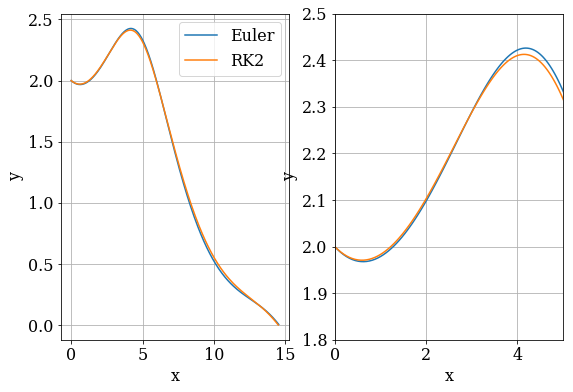

In [21]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

# Plot the glider's path for both schemes.
plt.figure(figsize=(9.0, 6.0))
plt.subplot(121)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
plt.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
plt.legend();
# Let's take a closer look!
plt.subplot(122)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_euler, y_euler, label='Euler')
plt.plot(x_rk2, y_rk2, label='RK2')
plt.xlim(0.0, 5.0)
plt.ylim(1.8, 2.5);

In [22]:
def leapfrog_step(prev_state, state, f, dt, *args):
    new_state = prev_state + 2.0 * dt * f(state, *args)
    return new_state

In [25]:
state_leapfrog = np.zeros([N,4])
state_leapfrog[0] = [v0, theta0, x0, y0]
state_leapfrog[1] = rk2_step(state_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)
for i in range(1, N-1):
    state_leapfrog[i+1] = leapfrog_step(state_leapfrog[i-1], state_leapfrog[i], rhs_phugoid, dt, CL, CD, g, vt)

In [26]:
x_leapfrog = state_leapfrog[:,2]
y_leapfrog = state_leapfrog[:,3]

idx_negative_leapfrog = np.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N-1
    print("No crash!")
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]
    print("Crash @ ", idx_ground_leapfrog)

Crash @  308


Distance traveled: 14.516


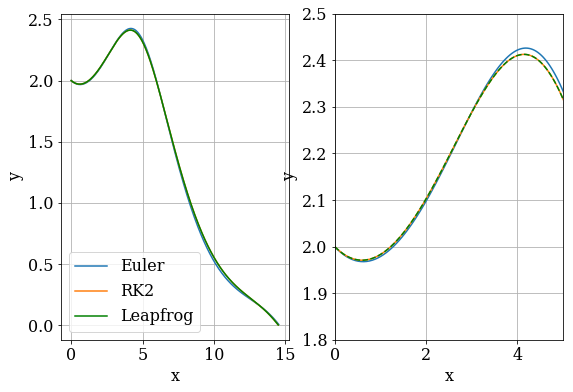

In [32]:

print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme.
plt.figure(figsize=(9.0, 6.0))
plt.subplot(121)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
plt.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
plt.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog], label='Leapfrog', color='green')
plt.legend()
# Let's take a closer look!
plt.subplot(122)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_euler, y_euler)
plt.plot(x_rk2, y_rk2)
plt.plot(x_leapfrog, y_leapfrog, color='g', linestyle='--')
plt.xlim(0.0, 5.0)
plt.ylim(1.8, 2.5);